In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from collections import defaultdict
from tqdm import tqdm
import time

In [2]:
from blackjack_double import BlackjackDoubleEnv
from blackjack_counting import BlackjackCountingEnv

## Часть первая, простейший блэкджек из gym

#### Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
def play_game(env, pi):
    observation = env.reset()
    done = False
    G = 0
    while not done:
        action = pi[s2idx[observation]]
        observation, reward, done, _ = env.step(action)
        G += reward
    return G

def evaluate_pi(env, pi, n=100000, tqdm_disable=False):
    rewards = []
    for _ in tqdm(range(n), disable=tqdm_disable):
        reward = play_game(env, pi)
        rewards.append(reward)
    return np.mean(rewards)

In [4]:
env = gym.make('Blackjack-v1')
env.natural = True
env.sab = True

In [5]:
A = (0, 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]

In [6]:
s2idx = {state: i for i, state in enumerate(S)}
pi_dummy = [int(state[0] not in {19, 20, 21}) for state, idx in s2idx.items()]

In [7]:
reward_mean = evaluate_pi(env, pi_dummy)
print(f'Оценка выигрыша при стратегии >= 19: {reward_mean:.5f}')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9543.15it/s]

Оценка выигрыша при стратегии >= 19: -0.19944


#### Реализуем метод обучения с подкреплением без модели используя окружение Blackjack-v1 из OpenAI Gym.

In [8]:
def Q_learning_episode(env, Q, A, alpha=0.0001, epsilon=0.1, gamma=1):
    
    s = s2idx[env.reset()]
    is_done = False
        
    while not is_done:
        a = np.argmax(Q[s]) if random.random() < (1 - epsilon) else random.choice(A)
        observation, r_new, is_done, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (r_new + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

def Q_learning(env, A, Q, episodes=50000, alpha=0.0001, epsilon=0.98, gamma=1):
    for _ in tqdm(range(episodes)):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
    return Q

In [10]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100000)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9160.00it/s]


In [11]:
pi = np.argmax(Q, axis=1)
reward_mean = evaluate_pi(env, pi)
print(f'Оценка выигрыша стратегии полученной Q обучением: {reward_mean:.4f}')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 9006.97it/s]

Оценка выигрыша стратегии полученной Q обучением: -0.0480


In [14]:
def plot_learinig(env, Q, A, alpha, epsilon, episodes=20000, n_eval=50000, step=1000):

    results = []
    episode_ixes =  []
    for episode_ix in tqdm(range(episodes)):
        Q = Q_learning_episode(env, Q, A, alpha=alpha, epsilon=epsilon)
        pi = np.argmax(Q, axis=1)
        if episode_ix % step == 0:
            results.append(evaluate_pi(env, pi, n=n_eval, tqdm_disable=True))
            episode_ixes.append(episode_ix)
            

    plt.figure(figsize=(16, 8))
    plt.plot(episode_ixes, results)
    plt.xlabel('Число эпизодов обучения')
    plt.ylabel('Награда')
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:12<00:00, 198.27it/s]


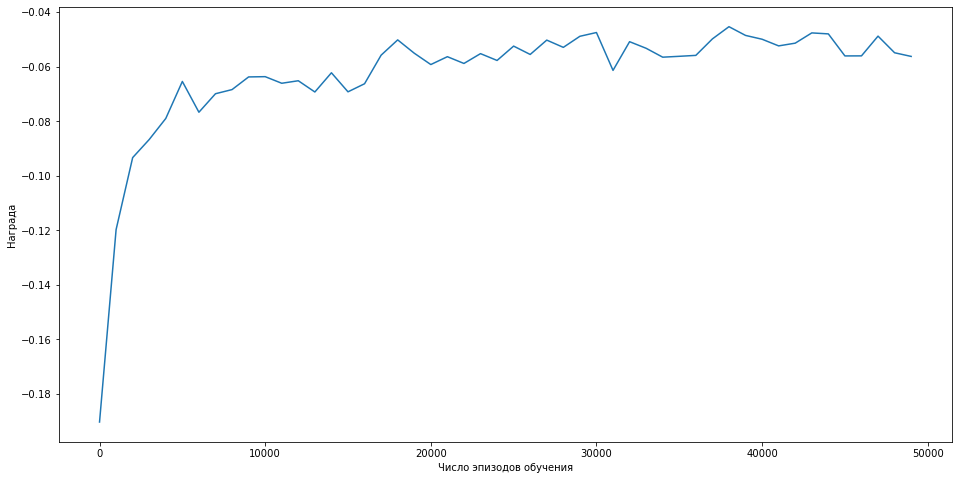

In [15]:
Q = np.zeros((len(S), len(A)))
plot_learinig(env, Q, A, alpha=0.0001, epsilon=0.95, episodes=50000, n_eval=50000, step=1000)

## Blackjack with doubling

In [16]:
env = BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [17]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, alpha=0.0001, epsilon=0.98, episodes=200000)
pi = np.argmax(Q, axis=1)
reward_mean = evaluate_pi(env, pi)

print(f'Оценка выигрыша в игре с double: {reward_mean:.4f}')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9487.83it/s]

Оценка выигрыша в игре с double: -0.0229


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:45<00:00, 349.73it/s]


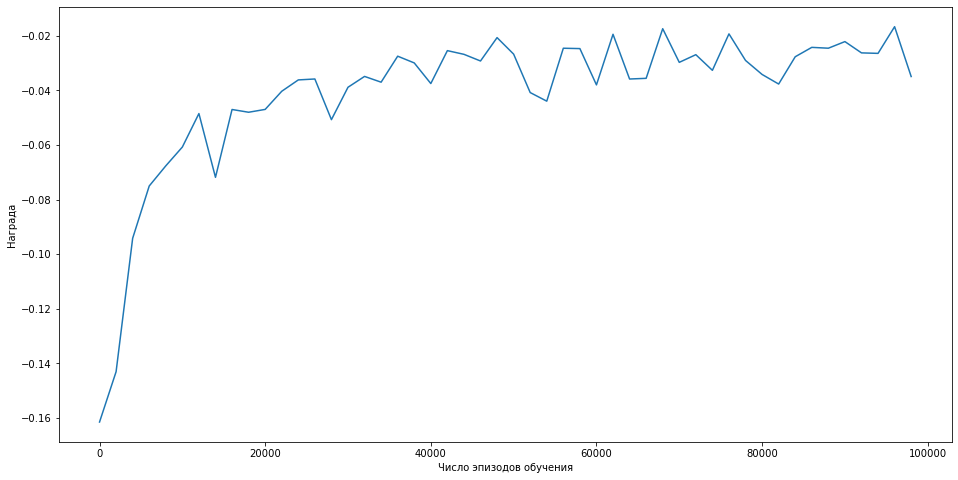

In [18]:
Q = np.zeros((len(S), len(A)))
plot_learinig(env, Q, A, alpha=0.0001, epsilon=0.95, episodes=100000, n_eval=50000, step=2000)

В целом уже недалеко от игры с нулевым проигрышем

## Blackjack with counting

In [19]:
env = BlackjackCountingEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [20]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=1000000, alpha=0.00015, epsilon=0.95)
pi = np.argmax(Q, axis=1)
reward_mean = evaluate_pi(env, pi, n=2000000)

print(f'Оценка выигрыша в игре с double и подсчетом карт: {reward_mean:.4f}')

100%|██████████████████████████████████████████████████████████████████████| 2000000/2000000 [10:41<00:00, 3119.09it/s]


Оценка выигрыша в игре с double и подсчетом карт: -0.0290


100%|██████████████████████████████████████████████████████████████████████| 2000000/2000000 [24:32<00:00, 1357.78it/s]


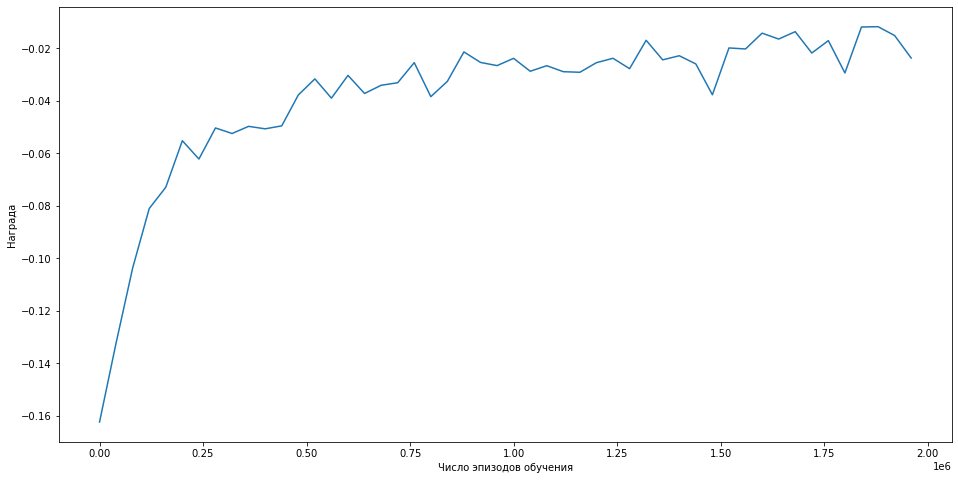

In [22]:
Q = np.zeros((len(S), len(A)))
plot_learinig(env, Q, A, alpha=0.00015, epsilon=0.95, episodes=2000000, n_eval=50000, step=40000)